In [165]:
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs

In [166]:
#Device agnostic

device = "cuda" if torch.cuda.is_available() else "cpu"

In [167]:
#Create data

X,Y = make_blobs(n_samples = 1000, n_features = 2, centers = 4, cluster_std=1.5, random_state= 42)

X[:2],Y[:2]

(array([[-8.41339595,  6.93516545],
        [-5.76648413, -6.43117072]]),
 array([3, 2]))

In [168]:
X.shape, Y.shape

((1000, 2), (1000,))

In [169]:
#Turn data into tensors, types, push into device

X = torch.from_numpy(X).type(torch.float32)
Y = torch.from_numpy(Y).type(torch.LongTensor)


In [170]:
#Split the dataset

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.2, random_state=42)

In [171]:
len(X_train), len(X_test)

(800, 200)

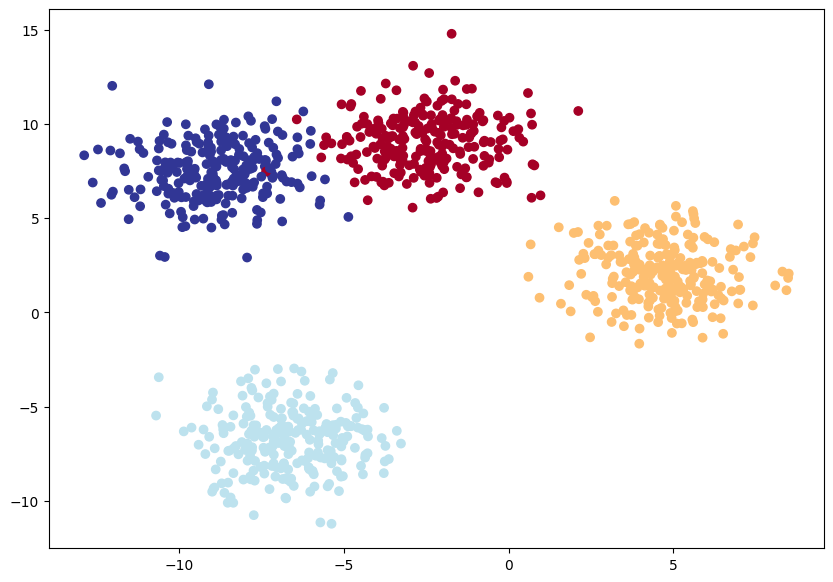

In [172]:
#Visualize our data
import matplotlib.pyplot as plt


plt.figure(figsize=(10,7))
plt.scatter(X[:,0], X[:,1], c=Y, cmap = plt.cm.RdYlBu)

In [173]:
#Build a mutliclass classsification model

class BlobModel(nn.Module):
  def __init__(self, input_features, output_features):
     super().__init__()
     self.linear_stack = nn.Sequential(
         nn.Linear(in_features=input_features, out_features = 10),
         nn.ReLU(),
         nn.Linear(in_features = 10, out_features=10),
         nn.ReLU(),
         nn.Linear(in_features = 10, out_features= 10),
         nn.ReLU(),
         nn.Linear(in_features = 10, out_features= output_features),
     )

  def forward(self,x:torch.Tensor) -> torch.Tensor:
    return self.linear_stack(x)



In [174]:
my_model = BlobModel(2, 4)

my_model.state_dict()

OrderedDict([('linear_stack.0.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('linear_stack.0.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('linear_stack.2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  

In [175]:
#Optimzer and loss function

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params = my_model.parameters(), lr = 0.01)

In [176]:
#Function for accuracy

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_true))*100
  return acc


In [177]:
#Training loop

torch.manual_seed(42)
torch.cuda.manual_seed(42)

#device agnostic
X_train, X_test = X_train.to(device), X_test.to(device)
Y_train, Y_test = Y_train.to(device), Y_test.to(device)

my_model = my_model.to(device)

epochs = 1000

for epoch in range(epochs):
  my_model.train()

  train_logits = my_model(X_train)
  train_pred = torch.argmax(torch.softmax(train_logits, dim = 1), dim = 1)

  loss = loss_function(train_logits, Y_train)
  train_acc = accuracy_fn(Y_train, train_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  #Evaluate
  my_model.eval()

  with torch.inference_mode():
    test_logits = my_model(X_test)
    test_pred = torch.argmax(torch.softmax(test_logits, dim = 1), dim = 1)

    test_loss = loss_function(test_logits, Y_test)
    test_acc = accuracy_fn(Y_test, test_pred)

  #Visualize visualize visualize
  if epoch%100 == 0:
    print(f"Epoch: {epoch} | Training loss: {loss:.4f}, Training accuracy: {train_acc:.2f}% | Test loss: {test_loss: .4f}, Test accuracy : {test_acc:.2f}%")


Epoch: 0 | Training loss: 1.3567, Training accuracy: 48.12% | Test loss:  1.3681, Test accuracy : 42.00%
Epoch: 100 | Training loss: 1.0827, Training accuracy: 69.12% | Test loss:  1.0939, Test accuracy : 68.00%
Epoch: 200 | Training loss: 0.7493, Training accuracy: 71.50% | Test loss:  0.7776, Test accuracy : 71.50%
Epoch: 300 | Training loss: 0.5634, Training accuracy: 74.12% | Test loss:  0.5930, Test accuracy : 73.50%
Epoch: 400 | Training loss: 0.3992, Training accuracy: 98.25% | Test loss:  0.4196, Test accuracy : 99.00%
Epoch: 500 | Training loss: 0.3118, Training accuracy: 98.75% | Test loss:  0.3251, Test accuracy : 99.50%
Epoch: 600 | Training loss: 0.2591, Training accuracy: 98.88% | Test loss:  0.2678, Test accuracy : 99.50%
Epoch: 700 | Training loss: 0.2210, Training accuracy: 98.88% | Test loss:  0.2261, Test accuracy : 99.50%
Epoch: 800 | Training loss: 0.1909, Training accuracy: 99.00% | Test loss:  0.1934, Test accuracy : 99.50%
Epoch: 900 | Training loss: 0.1665, Tra

# Model evaluation !!!

In [178]:
my_model.eval()

with torch.inference_mode():
  test_logits = my_model(X_test)
  test_pred = torch.argmax(torch.softmax(test_logits, dim = 1), dim =1)

Y_test[:20], test_pred[:20]


(tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3],
        device='cuda:0'),
 tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3],
        device='cuda:0'))

In [179]:
import requests
from pathlib import Path

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Download helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_function.py", "wb") as f:
    f.write(request.content)

from helper_function import plot_decision_boundary

Download helper_functions.py


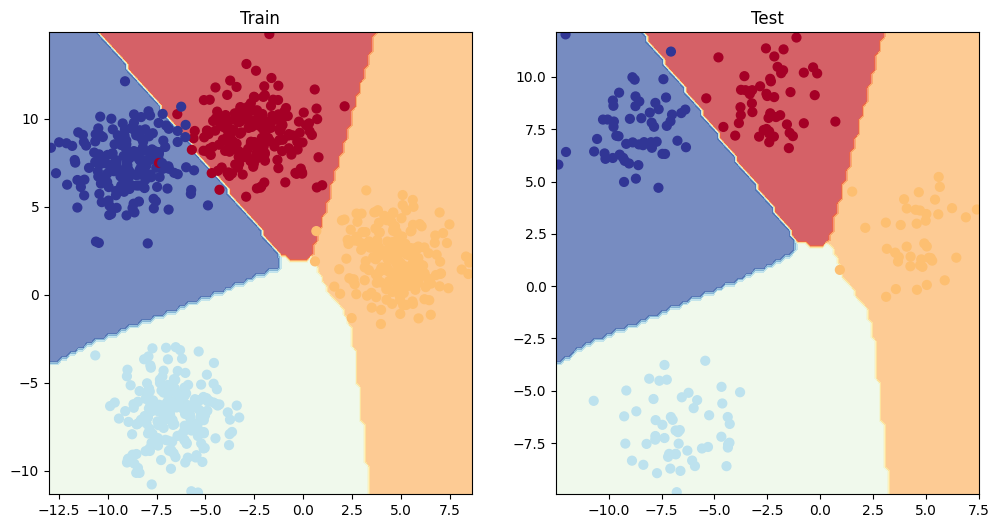

In [180]:
#Visualize using plt

plt.figure(figsize =(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(my_model, X_train, Y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(my_model, X_test, Y_test)
